In [1]:
import numpy as np

import repeated_play

import axelrod as axl

In [2]:
import itertools

from axelrod.action import Action

C, D = Action.C, Action.D

In [17]:
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt

In [4]:
import networkx as nx

In [5]:
from collections import Counter

In [59]:
from scipy import stats

In [6]:
def match_payoffs(player, coplayer, Sx, Sy, memory="one"):
    M = repeated_play.transition_matrix_repeated_game(
        player, coplayer, memory=memory
    )

    ss = repeated_play.stationary_distribution(M)[0]

    return ss, ss @ Sx, ss @ Sy

In [7]:
def reactive_two_t_memory_two(strategy):
    return (strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3],
            strategy[0], strategy[1], strategy[0], strategy[1],
            strategy[2], strategy[3], strategy[2], strategy[3]
           )

In [8]:
player = [0.99, 0.1, 0.6, 0.3]

prime_player = [0.99, 0.6, 0.1, 0.3]

In [9]:
player_mem2 = reactive_two_t_memory_two(player)

In [10]:
prime_player_mem2 = reactive_two_t_memory_two(prime_player)

In [11]:
b, c = 1, 1/2

Sx = np.array([b - c, -c, b, 0] * 4)

Sy = np.array([b - c, b, -c, 0] * 4)

In [12]:
ss, payoff, _ = match_payoffs(player_mem2, player_mem2, Sx, Sy, memory="two")

In [13]:
ss2, payoff2, _ = match_payoffs(prime_player_mem2, prime_player_mem2, Sx, Sy, memory="two")

# Simulations

In [14]:
class Mem2Transformed(axl.MemoryTwoPlayer):
    
    
    def __init__(self, sixteen_vector) -> None:
        super().__init__(sixteen_vector)
        
    def strategy(self, opponent):
        """Actual strategy definition that determines player's action."""
        turn = len(self.history)
        if turn <= 1:
            return self._random.random_choice(0.5)

        p = self._sixteen_vector[
            ((self.history[-2], opponent.history[-2]), (self.history[-1], opponent.history[-1]))
        ]

        try:
            return self._random.random_choice(p)
        except AttributeError:
            return C if p == 1 else D

In [15]:
donation = axl.game.Game(r=b-c, s=-c, t=b, p=0)

### Player

In [16]:
reps = 20

In [36]:
scores, results_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(player_mem2)
    
    p2 = Mem2Transformed(player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores.append(score)
    
    results_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [37]:
results_flatten = [x for xs in results_player for x in xs]

states_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten[:-1]):
    states_player[hist + results_flatten[i + 1]] += 1 / (10 ** 6 * reps)

In [38]:
scores2, results_prime_player = [], []

for _ in tqdm(range(reps)):
    
    p1 = Mem2Transformed(prime_player_mem2)
    
    p2 = Mem2Transformed(prime_player_mem2)
    
    match = axl.Match([p1, p2], turns=10**6, game=donation)
    
    _ = match.play()
    
    score = match.final_score_per_turn()[0]
    
    scores2.append(score)
    
    results_prime_player.append(match.result)

  0%|          | 0/20 [00:00<?, ?it/s]

In [39]:
results_flatten2 = [x for xs in results_prime_player for x in xs]

states_prime_player = {history: 0 for history in  itertools.product([C, D], repeat=4)}

for i, hist in enumerate(results_flatten2[:-1]):
    states_prime_player[hist + results_flatten2[i + 1]] += 1 / (10 ** 6 * reps)

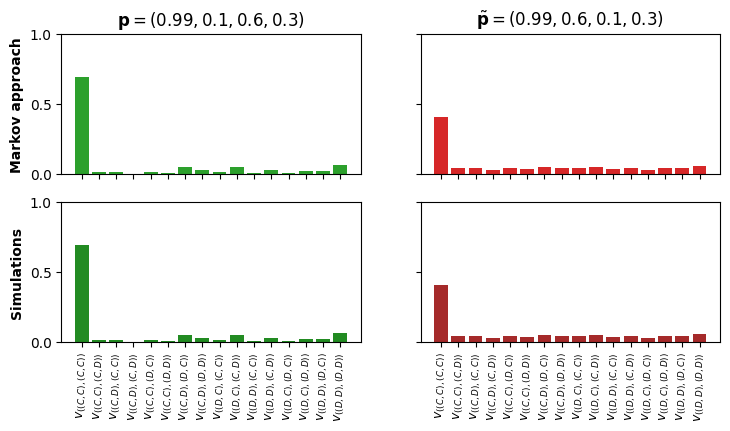

In [157]:
fig, axes = plt.subplot_mosaic("AB;CD", figsize=(8.5, 4),
                               gridspec_kw = {'height_ratios':[1, 1]},
                               sharey=True,
                               sharex=True)

# Markov chain process
axes["A"].bar(range(1, 17), ss, color='tab:green');

axes["B"].bar(range(1, 17), ss2, color='tab:red');

# Simulations

axes["C"].bar(range(1, 17), states_player.values(), color='forestgreen');

axes["D"].bar(range(1, 17), states_prime_player.values(), color='brown');



# ticks and stuff

axes["A"].set_ylim(0, 1)

axes["A"].set_yticks(np.arange(0, 1.1, .5));

axes["A"].set_xticks(np.arange(1, 17, 1));

for letter in ['C', 'D']:

    axes[letter].set_xticklabels(['$v_{((C, C), (C, C))}$',
                               '$v_{((C, C), (C, D))}$',
                               '$v_{((C, D), (C, C))}$',
                               '$v_{((C, D), (C, D))}$',
                               '$v_{((C, C), (D, C))}$',
                               '$v_{((C, C), (D, D))}$',
                               '$v_{((C, D), (D, C))}$',
                               '$v_{((C, D), (D, D))}$',
                               '$v_{((D, C), (C, C))}$',
                               '$v_{((D, C), (C, D))}$',
                               '$v_{((D, D), (C, C))}$',
                               '$v_{((D, D), (C, D))}$',
                               '$v_{((D, C), (D, C))}$',
                               '$v_{((D, C), (D, D))}$',
                               '$v_{((D, D), (D, C))}$',
                               '$v_{((D, D), (D, D))}$'], rotation=90, fontsize=9
                         );

    axes[letter].xaxis.set_tick_params(labelbottom=True)
    
axes['A'].set_title("$\mathbf{p}=(0.99, 0.1, 0.6, 0.3)$");

axes['B'].set_title(r"$\mathbf{\tilde{p}}=(0.99, 0.6, 0.1, 0.3)$");


axes['A'].set_ylabel("Markov approach", fontweight='bold');

axes['C'].set_ylabel("Simulations", fontweight='bold');

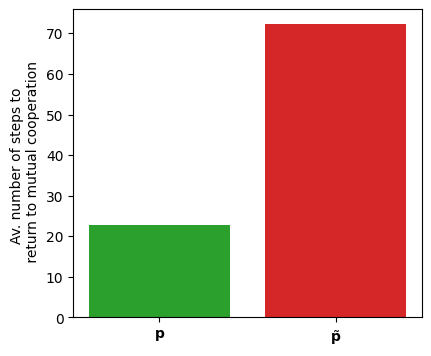

In [159]:
fig, axes = plt.subplot_mosaic("A", figsize=(4.5, 4),
                               gridspec_kw = {'height_ratios':[1]},
                               sharey=True,
                               sharex=True)

axes["A"].bar([0, 1],
             [np.mean([len(cycle) - 2 for cycle in flatten_cycles_player]),
              np.mean([len(cycle) - 2 for cycle in flatten_cycles_prime_player])],
              color=['tab:green', 'tab:red']);

axes["A"].set_xticks([0, 1], ["$\mathbf{p}$", r"$\mathbf{\tilde{p}}$"]);

axes["A"].set_ylabel("Av. number of steps to \n return to mutual cooperation");

In [150]:
np.mean([len(cycle) - 2 for cycle in flatten_cycles_player])

22.87816491713841

# Cycles

Let's transform the histories to letters. More specifically,

- (C, C) -> A
- (C, D) -> B
- (D, C) -> C
- (D, D) -> D

In [41]:
states_to_letters = {(C, C): "A", (C, D): "B", (D, C): "C", (D, D): "D"}

In [42]:
results_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_player]

Let's write the function for getting cycles

In [43]:
def get_cycles(result):

    overall_cycles = []

    source = ["A", "A"]

    current_cycle = []

    cycle_happening = False

    for i, turn in enumerate(result[:-1]):

        state = [turn, result[i + 1]]

        if state == source and cycle_happening == False:
            cycle_happening = True

            current_cycle = [state]

        elif state == source and len(current_cycle) == 1:
            assert cycle_happening == True
            current_cycle = [state]


        elif state == source and len(current_cycle) > 1:
            assert cycle_happening == True

            current_cycle.append(state)
            overall_cycles.append(current_cycle)

            current_cycle = []
            cycle_happening = False


        elif state != source and cycle_happening == True:
            assert cycle_happening == True
            current_cycle.append(state)
        else:
            pass
    return overall_cycles

Let's test it.

In [26]:
result = ["A", "A", "A"]

get_cycles(result)

[]

In [27]:
result = ["A", "A", "B", "D"]

get_cycles(result)

[]

In [28]:
result = ["A", "A", "B", "D", "A", "A", "C", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [29]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

In [30]:
result = ["A", "A", "B", "D", "A", "A", "C", "D", "A", "A", "B", "D", "A", "A",]

get_cycles(result)

[[['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']],
 [['A', 'A'], ['A', 'B'], ['B', 'D'], ['D', 'A'], ['A', 'A']]]

Let's transform both results.

In [31]:
results_prime_player_letters = [[states_to_letters[state] for state in states] 
                          for states in results_prime_player]

Let's get the cycles.

In [44]:
cycles_player = []

for result in results_player_letters:
    cycles = get_cycles(result)
    cycles_player.append(cycles)

In [34]:
# [len(cycle) for cycle in cycles_player]

In [45]:
sum([len(cycle) for cycle in cycles_player])

267977

In [46]:
flatten_cycles_player = [x for xs in cycles_player for x in xs]

In [47]:
np.mean([len(cycle) for cycle in flatten_cycles_player])

24.87816491713841

Let's get the cycles for prime player.

In [48]:
cycles_prime_player = []

for result in results_prime_player_letters:
    cycles = get_cycles(result)
    cycles_prime_player.append(cycles)

In [49]:
sum([len(cycle) for cycle in cycles_prime_player])

15983

In [50]:
flatten_cycles_prime_player = [x for xs in cycles_prime_player for x in xs]

In [51]:
np.mean([len(cycle) for cycle in flatten_cycles_prime_player])

74.27954701870738

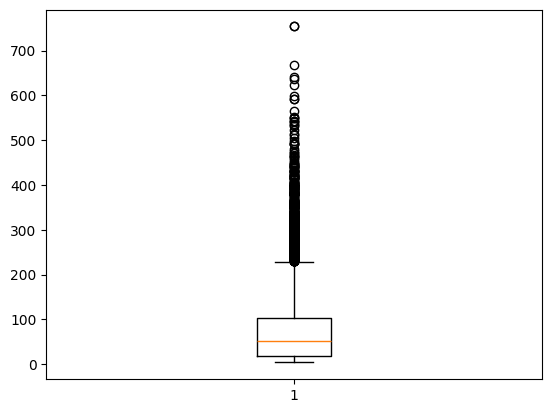

In [54]:
plt.boxplot([len(cycle) for cycle in flatten_cycles_prime_player]);

In [60]:
stats.mode([len(cycle) for cycle in flatten_cycles_prime_player])

/var/folders/19/1t7slkb13h578dr5bl_47kf80000gp/T/ipykernel_9101/3230808305.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode([len(cycle) for cycle in flatten_cycles_prime_player])


ModeResult(mode=array([4]), count=array([907]))

In [61]:
stats.mode([len(cycle) for cycle in flatten_cycles_player])

/var/folders/19/1t7slkb13h578dr5bl_47kf80000gp/T/ipykernel_9101/1707562091.py:1: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  stats.mode([len(cycle) for cycle in flatten_cycles_player])


ModeResult(mode=array([4]), count=array([15633]))

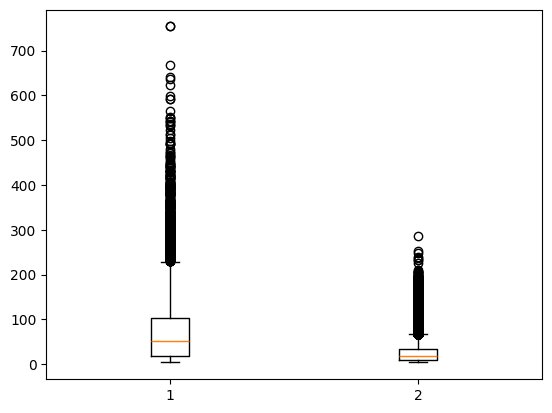

In [66]:
plt.boxplot([[len(cycle) for cycle in flatten_cycles_prime_player],
            [len(cycle) for cycle in flatten_cycles_player]]);


In [76]:
c = Counter([len(cycle) for cycle in flatten_cycles_prime_player])

In [81]:
c.most_common(5)

[(4, 907), (6, 617), (8, 470), (10, 359), (12, 274)]

In [82]:
c = Counter([len(cycle) for cycle in flatten_cycles_player])

In [83]:
c.most_common(5)

[(4, 15633), (8, 10466), (9, 10177), (7, 9668), (10, 9409)]

Let's write it as sequence so we can find duplicates and the most common cycles.

In [84]:
sequences_player = []

for cycle in flatten_cycles_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_player.append(sequence)

In [85]:
len(sequences_player)

267977

In [86]:
count = Counter(sequences_player)

In [87]:
count.most_common(15)

[('AA-AB-BA-AA', 7903),
 ('AA-AC-CA-AA', 7724),
 ('AA-AB-BC-CA-AA', 4272),
 ('AA-AC-CB-BA-AA', 4172),
 ('AA-AB-BC-CB-BA-AA', 2298),
 ('AA-AC-CB-BC-CA-AA', 2288),
 ('AA-AB-BC-CD-DC-CA-AA', 1282),
 ('AA-AB-BC-CB-BC-CA-AA', 1248),
 ('AA-AC-CB-BC-CB-BA-AA', 1201),
 ('AA-AC-CB-BD-DB-BA-AA', 1180),
 ('AA-AB-BC-CD-DD-DA-AA', 890),
 ('AA-AB-BC-CC-CA-AA', 850),
 ('AA-AC-CB-BB-BA-AA', 839),
 ('AA-AC-CB-BD-DD-DA-AA', 820),
 ('AA-AB-BC-CB-BD-DB-BA-AA', 675)]

In [88]:
sequences_prime_player = []

for cycle in flatten_cycles_prime_player:

    sequence = "-".join(["".join(state) for state in cycle])
    
    sequences_prime_player.append(sequence)

In [89]:
len(sequences_prime_player)

15983

In [90]:
count_prime = Counter(sequences_prime_player)

In [91]:
count_prime.most_common(15)

[('AA-AB-BA-AA', 456),
 ('AA-AC-CA-AA', 451),
 ('AA-AB-BA-AC-CA-AA', 269),
 ('AA-AC-CA-AB-BA-AA', 242),
 ('AA-AB-BA-AC-CA-AB-BA-AA', 148),
 ('AA-AC-CA-AB-BA-AC-CA-AA', 134),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 80),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 74),
 ('AA-AC-CB-BB-BA-AA', 54),
 ('AA-AB-BC-CC-CA-AA', 41),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AB-BA-AA', 37),
 ('AA-AC-CA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 31),
 ('AA-AC-CA-AB-BC-CC-CA-AA', 31),
 ('AA-AC-CB-BB-BA-AC-CA-AA', 29),
 ('AA-AB-BA-AC-CA-AB-BA-AC-CA-AB-BA-AC-CA-AA', 28)]

# Figure

In [102]:
['((C, C), (C, C))', '((C, C), (C, D))', '((C, D), (C, C))', '((C, D), (C, D))'] * 4

['((C, C), (C, C))',
 '((C, C), (C, D))',
 '((C, D), (C, C))',
 '((C, D), (C, D))',
 '((C, C), (C, C))',
 '((C, C), (C, D))',
 '((C, D), (C, C))',
 '((C, D), (C, D))',
 '((C, C), (C, C))',
 '((C, C), (C, D))',
 '((C, D), (C, C))',
 '((C, D), (C, D))',
 '((C, C), (C, C))',
 '((C, C), (C, D))',
 '((C, D), (C, C))',
 '((C, D), (C, D))']

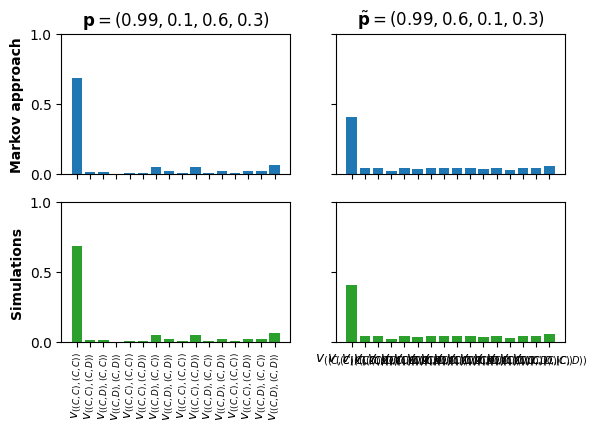

In [131]:
fig, axes = plt.subplot_mosaic("AB;CD", figsize=(6.5, 4),
                               gridspec_kw = {'height_ratios':[1, 1]},
                               sharey=True,
                               sharex=True)

# Markov chain process
axes["A"].bar(range(1, 17), ss);

axes["B"].bar(range(1, 17), ss2);

# Simulations

axes["C"].bar(range(1, 17), states_player.values(), color='tab:green');

axes["D"].bar(range(1, 17), states_prime_player.values(), color='tab:green');



# ticks and stuff

axes["A"].set_ylim(0, 1)

axes["A"].set_yticks(np.arange(0, 1.1, .5));

axes["C"].set_xticks(np.arange(1, 17, 1));

axes["C"].set_xticklabels(['$v_{((C, C), (C, C))}$',
                           '$v_{((C, C), (C, D))}$',
                           '$v_{((C, D), (C, C))}$',
                           '$v_{((C, D), (C, D))}$'] * 4, rotation=90, fontsize=9
                     );

axes["C"].xaxis.set_tick_params(labelbottom=True)

    
axes['A'].set_title("$\mathbf{p}=(0.99, 0.1, 0.6, 0.3)$");

axes['B'].set_title(r"$\mathbf{\tilde{p}}=(0.99, 0.6, 0.1, 0.3)$");


axes['A'].set_ylabel("Markov approach", fontweight='bold');

axes['C'].set_ylabel("Simulations", fontweight='bold');


### Transitions

In [277]:
transitions =  {history: [] for history in  itertools.product([C, D], repeat=4)}

states_map = {history: (i + 1) for i, history in  enumerate(itertools.product([C, D], repeat=4))}

In [278]:
len(results), len(results[0])

(10, 100000)

In [279]:
for result in results2:

    for i, hist in enumerate(result[:-2]):
        val = states_map[result[i + 1] + result[i + 2]]
        transitions[hist + result[i + 1]].append(val)

In [280]:
array_transitions = np.zeros((16, 16))

for i, (key, vals) in enumerate(transitions.items()):
    
    for j in range(1, 17):
        
        array_transitions[i, j -1] = vals.count(j)

In [281]:
sum(sum(array_transitions)) == 10 * (10 ** 5 - 2)

True

In [282]:
row_sums = array_transitions.sum(axis=1)

transitions_normalised_array = array_transitions / row_sums[:, np.newaxis]

In [283]:
transitions_normalised_array[transitions_normalised_array < 2 * 10 ** -1] = 0

In [284]:
# np.fill_diagonal(array_transitions, 0)

In [285]:
G = nx.from_numpy_array(transitions_normalised_array,
                        create_using=nx.MultiDiGraph())

In [286]:
states_map_T =   { 0: "CC|CC",
  1: "CC|CD",
  2: "CC|DC",
  3: "CC|DD",
  4: "CD|CC",
  5: "CD|CD",
  6: "CD|DC",
  7: "CD|DD",
  8: "DC|CC",
  9: "DC|CD",
  10: "DC|DC",
  11: "DC|DD",
  12: "DD|CC",
  13: "DD|CD",
  14: "DD|DC",
  15: "DD|DD"}

In [287]:
options = {
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'arrows': True
}

In [288]:
G = nx.relabel_nodes(G, states_map_T)

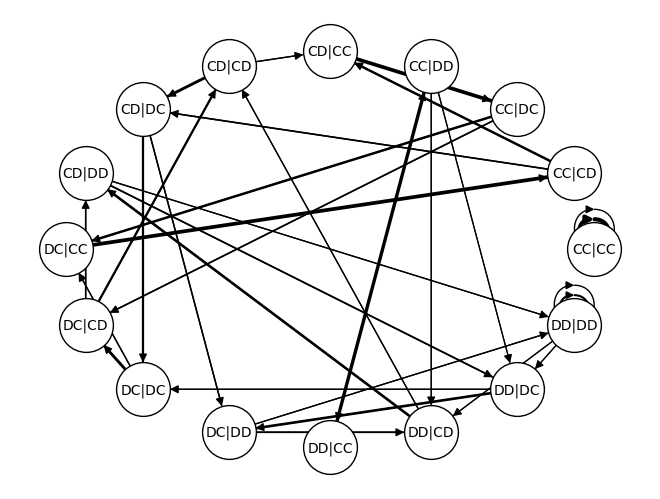

In [289]:
pos = nx.circular_layout(G)

nx.draw(G, pos=pos, node_size=1500, node_color='white', edgecolors='black', **options)

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif");

for edge in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2] * 3)

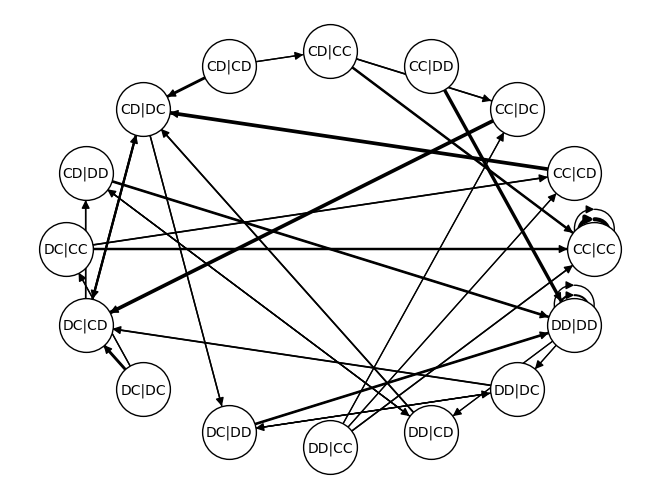

In [276]:
pos = nx.circular_layout(G)

nx.draw(G, pos=pos, node_size=1500, node_color='white', edgecolors='black', **options)

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif");

for edge in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2] * 3)

# $p$ prime

In [67]:
transitions =  {history: [] for history in  itertools.product([C, D], repeat=4)}

states_map = {history: (i + 1) for i, history in  enumerate(itertools.product([C, D], repeat=4))}

In [68]:
for result in results2:

    for i, hist in enumerate(result[:-2]):
        val = states_map[result[i + 1] + result[i + 2]]
        transitions[hist + result[i + 1]].append(val)

In [69]:
array_transitions2 = np.zeros((16, 16))

for i, (key, vals) in enumerate(transitions.items()):
    
    for j in range(1, 17):
        
        array_transitions2[i, j -1] = vals.count(j)

In [ ]:
# np.fill_diagonal(array_transitions2, 0)

In [ ]:
array_transitions2 = array_transitions2 / sum(sum(array_transitions2))

In [70]:
G = nx.from_numpy_array(array_transitions2, create_using=nx.MultiDiGraph())

In [ ]:
# G.remove_nodes_from(list(nx.isolates(G)))

In [75]:
np.mean([len(path) for path in list(nx.all_simple_paths(G, "CC|CC", "CD|CC"))])

13.910114305507447

In [76]:
np.mean([len(path) for path in list(nx.all_simple_paths(G, "CC|CC", "DC|CC"))])

13.910114305507447

In [77]:
np.mean([len(path) for path in list(nx.all_simple_paths(G, "CC|CC", "DD|CC"))])

13.910114305507447

In [94]:
cycles_we_want = []

for cycle in nx.simple_cycles(G):
    if cycle[0] == 'CC|CC':
        cycles_we_want.append(cycle)
        

In [95]:
cycles_we_want

[['CC|CC']]

In [86]:
G.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15))

In [73]:
states_map_T =   { 0: "CC|CC",
  1: "CC|CD",
  2: "CC|DC",
  3: "CC|DD",
  4: "CD|CC",
  5: "CD|CD",
  6: "CD|DC",
  7: "CD|DD",
  8: "DC|CC",
  9: "DC|CD",
  10: "DC|DC",
  11: "DC|DD",
  12: "DD|CC",
  13: "DD|CD",
  14: "DD|DC",
  15: "DD|DD"}

In [74]:
G = nx.relabel_nodes(G, states_map_T)

In [89]:
options = {
    'arrowstyle': '-|>',
    'arrowsize': 12,
    'arrows': True
}

In [ ]:
pos = nx.circular_layout(G)

nx.draw(G, pos=pos, node_size=1500, node_color='white', edgecolors='black', **options)

nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif");

for edge in G.edges(data='weight'):
#     print(edge)
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2] * 60)

# edge_labels = nx.get_edge_attributes(G, "weight")

# nx.draw_networkx_edge_labels(G, pos, edge_labels);

In [ ]:
cycles_we_want = []

for cycle in nx.simple_cycles(G):
    if cycle[0] == 'CC|CC':
        if len(cycle) < 5:
            cycles_we_want.append(cycle)
        

In [ ]:
cycles_we_want

# Trying for the figure

In [190]:
transitions =  {history: [] for history in  itertools.product([C, D], repeat=4)}

states_map = {history: (i + 1) for i, history in  enumerate(itertools.product([C, D], repeat=4))}

In [191]:
for result in results:

    for i, hist in enumerate(result[:-2]):
        val = states_map[result[i + 1] + result[i + 2]]
        transitions[hist + result[i + 1]].append(val)

In [192]:
array_transitions = np.zeros((16, 16))

for i, (key, vals) in enumerate(transitions.items()):
    
    for j in range(1, 17):
        
        array_transitions[i, j -1] = vals.count(j)

In [193]:
sum(sum(array_transitions)) == 10 * (10 ** 5 - 2)

True

In [194]:
row_sums = array_transitions.sum(axis=1)

transitions_normalised_array = array_transitions / row_sums[:, np.newaxis]

In [195]:
transitions =  {history: [] for history in  itertools.product([C, D], repeat=4)}

states_map = {history: (i + 1) for i, history in  enumerate(itertools.product([C, D], repeat=4))}

In [27]:
for result in results2:

    for i, hist in enumerate(result[:-2]):
        val = states_map[result[i + 1] + result[i + 2]]
        transitions[hist + result[i + 1]].append(val)

In [28]:
array_transitions2 = np.zeros((16, 16))

for i, (key, vals) in enumerate(transitions.items()):
    
    for j in range(1, 17):
        
        array_transitions2[i, j -1] = vals.count(j)

In [29]:
row_sums = array_transitions2.sum(axis=1)

transitions_normalised_array2 = array_transitions2 / row_sums[:, np.newaxis]

In [34]:
i = 12

sum(transitions_normalised_array[:, i]), sum(transitions_normalised_array2[:, i])

(0.16374374757879867, 0.8066430029197832)

In [ ]:
ss[4], ss2[4]

In [ ]:
(1 - 0.99) * (1 - 0.99)

In [ ]:
transitions_normalised_array[:, 4]

In [ ]:
ss2

In [ ]:
transitions_normalised_array[:, 1]

In [ ]:
transitions_normalised_array2[0, :].round(4)

In [ ]:
transitions_normalised_array[1, :].round(4)

In [ ]:
transitions_normalised_array2[1, :].round(4)

## Get the paths myself

In [145]:
def get_cycles(result):

    overall_cycles = []

    source = [(C, C), (C, C)]

    current_cycle = []

    cycle_happening = False

    for i, turn in enumerate(result[:-2]):

        state = [turn, result[i + 1]]

        if state == source and cycle_happening == False:
            cycle_happening = True

            current_cycle = [state]

        elif state == source and len(current_cycle) == 1:
            assert cycle_happening == True
            current_cycle = [state]


        elif state == source and len(current_cycle) > 1:
            assert cycle_happening == True

            current_cycle.append(state)
            overall_cycles.append(current_cycle)

            current_cycle = []
            cycle_happening = False


        elif state != source and cycle_happening == True:
            assert cycle_happening == True
            current_cycle.append(state)
        else:
            pass
    return overall_cycles

In [168]:
cycles1 = [get_cycles(result) for result in results]

In [169]:
len(cycles2[0])

30

In [170]:
cycles2 = [get_cycles(result) for result in results2]

In [171]:
[len(cycle) for cycle in cycles1]

[1309, 1360, 1364, 1360, 1289, 1322, 1298, 1317, 1343, 1403]

In [172]:
[len(cycle) for cycle in cycles2]

[769, 776, 757, 798, 805, 822, 802, 779, 819, 821]

In [173]:
cycles1 = [x for xs in cycles1 for x in xs]

In [174]:
cycles2 = [x for xs in cycles2 for x in xs]

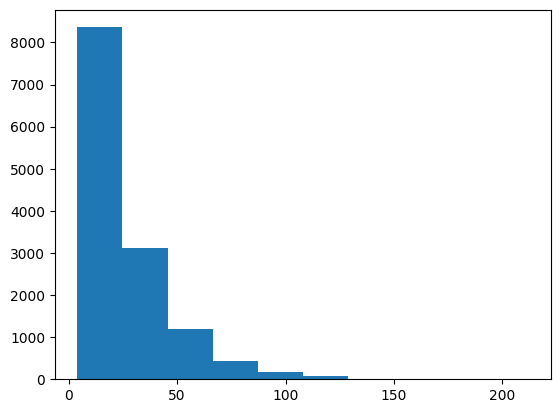

In [179]:
plt.hist([len(c) for c in cycles1]);

(array([5.264e+03, 1.661e+03, 6.590e+02, 2.250e+02, 9.400e+01, 2.300e+01,
        1.500e+01, 4.000e+00, 0.000e+00, 3.000e+00]),
 array([  4. ,  80.5, 157. , 233.5, 310. , 386.5, 463. , 539.5, 616. ,
        692.5, 769. ]),
 <BarContainer object of 10 artists>)

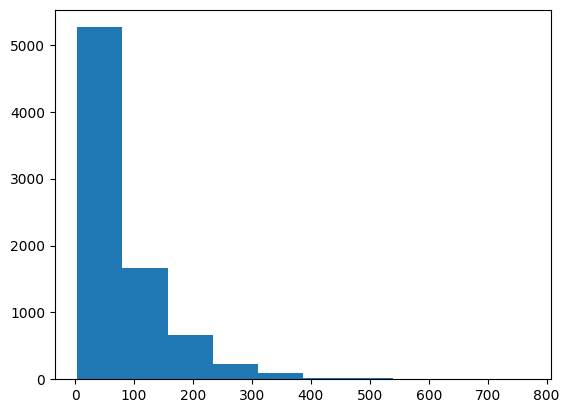

In [180]:
plt.hist([len(c) for c in cycles2])

In [189]:
cycles1[0]

[[(C, C), (C, C)],
 [(C, C), (D, C)],
 [(D, C), (C, D)],
 [(C, D), (C, C)],
 [(C, C), (C, C)]]